In [27]:
import torch
import json
import yaml
import pprint
from torch.utils.data import Dataset, DataLoader
from model import HierarchicalInterviewScorer
from dataset import HierarchicalInterviewDataset
from eval import calculate_feedback
from trainer import Trainer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from model_utils import tokenize_dialogue, predict_scores, format_scores, get_turn_attention_weights


In [45]:
def load_trained_model(checkpoint_path, device="cuda"):
    model = HierarchicalInterviewScorer(hidden_size=768, num_dialogue_layers=2, dropout=0.3)
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    #model.eval()
    return model

checkpoint_path = "/home/hice1/wyue9/scratch/CS6220/test/checkpoint1.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_trained_model(checkpoint_path, device=device)


/home/hice1/wyue9/scratch/miniconda3/envs/nl2prot/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/hice1/wyue9/scratch/miniconda3/envs/nl2prot/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/scratch/998919/ipykernel_876857/3967878655.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#

In [46]:
val_data_path = "data/val_data.json"
with open(val_data_path, "r") as f:
    val_data = json.load(f)

print(f"Number of validation samples: {len(val_data)}")
sample_key = list(val_data.keys())[0]
sample = val_data[sample_key]
print("Sample Dialogue:", sample["Transcript"])
print("Ground Truth Scores:", sample.get("Overall"), sample.get("RecommendHiring"), sample.get("StructuredAnswers"))


Number of validation samples: 28
Sample Dialogue: Interviewer:  How are you doing today?|Interviewee:  Good  how are you?|Interviewer:  Good.  Tell me more about your background.|Interviewee:  So  my background is primarily in energy work.  So  I'm a chemical engineering student and I'm very interested in not only alternative energy but the optimization of our traditional energy resources.  Um  so that's  that's where my  uh  background in  well in gas comes in.  Um  but also some of my research interests are you know  kind of scientific ideas.||Interviewer:  Great.  Um  do you think you're a leader.  Tell me why.|Interviewee: Um  I definitely think I am.  Uh  partially because even when I'm not the designated leader somehow it turns into me leading the team.  But I really enjoy that.  I think that one of the most satisfying feelings is having your team tel you that you're doing a great job or that they think that um that success can be highly attributed to you.  So  I think that in te

In [47]:
def prepare_sample(sample, max_turns=20, max_length=512):
    dialogue_turns = sample["Transcript"].split("|")
    tokenized_input = tokenize_dialogue(dialogue_turns, max_turns=max_turns, max_length=max_length)
    return dialogue_turns, tokenized_input

dialogue_turns, tokenized_input = prepare_sample(sample)


In [50]:
tokenized_input = {k: v.to(device) for k, v in tokenized_input.items()}

print(f"Device of input_ids: {tokenized_input['input_ids'].device}")
print(f"Device of attention_mask: {tokenized_input['attention_mask'].device}")
print(f"Model device: {next(model.parameters()).device}")

with torch.no_grad():
    predicted_scores, attention_weights = model(tokenized_input)

formatted_scores = format_scores(predicted_scores.squeeze(0).cpu().numpy())
print("\nPredicted Scores:")
for label, score in formatted_scores.items():
    print(f"{label}: {score:.2f}")


Device of input_ids: cuda:0
Device of attention_mask: cuda:0
Model device: cuda:0

Predicted Scores:
Overall Score: 5.02
Recommendation Score: 4.01
Structured Answers Score: 4.39


In [51]:
def plot_attention_weights(attention_weights, dialogue_turns):
    """
    Plot attention weights for dialogue turns.
    """
    attention_weights = attention_weights.squeeze(0).cpu().numpy()
    if len(attention_weights.shape) > 1:
        attention_weights = attention_weights.mean(axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(dialogue_turns)), attention_weights, color='blue', alpha=0.7)
    plt.xticks(range(len(dialogue_turns)), dialogue_turns, rotation=45, ha='right')
    plt.xlabel("Dialogue Turns")
    plt.ylabel("Attention Weight")
    plt.title("Turn-Level Attention Scores")
    plt.tight_layout()
    plt.show()

plot_attention_weights(attention_weights, dialogue_turns)


/scratch/998919/ipykernel_876857/819764164.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [4]:
# Move tokenized input to the same device as the model
tokenized_dialogue = {k: v.to(device) for k, v in tokenized_dialogue.items()}

# Run the model
with torch.no_grad():
    predicted_scores, attention_scores = model(tokenized_dialogue)

# Convert scores to a more readable format
predicted_scores = predicted_scores.squeeze(0).cpu().numpy()  # Convert to numpy array
categories = ["Overall Score", "Recommendation Score", "Structured Answers Score"]
formatted_scores = {category: round(score, 2) for category, score in zip(categories, predicted_scores)}

# Print the scores
print("Predicted Scores for the New Dialogue:")
for category, score in formatted_scores.items():
    print(f"{category}: {score}")


Predicted Scores for the New Dialogue:
Overall Score: -0.09000000357627869
Recommendation Score: -0.30000001192092896
Structured Answers Score: 0.09000000357627869


In [9]:
def plot_attention_weights(attention_weights, dialogue_turns):
    """
    Plot a bar chart to show turn importance based on attention weights.
    """
    # Ensure attention_weights is 1D and a NumPy array
    attention_weights = attention_weights.squeeze()
    if len(attention_weights.shape) > 1:
        attention_weights = attention_weights[0]  # Select first batch if necessary
    attention_weights = attention_weights.cpu().numpy()  # Convert to NumPy
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(dialogue_turns)), attention_weights, color='blue', alpha=0.7)
    plt.xticks(range(len(dialogue_turns)), dialogue_turns, rotation=45, ha='right')
    plt.xlabel("Dialogue Turns")
    plt.ylabel("Attention Weight")
    plt.title("Turn-Level Attention Scores")
    plt.show()


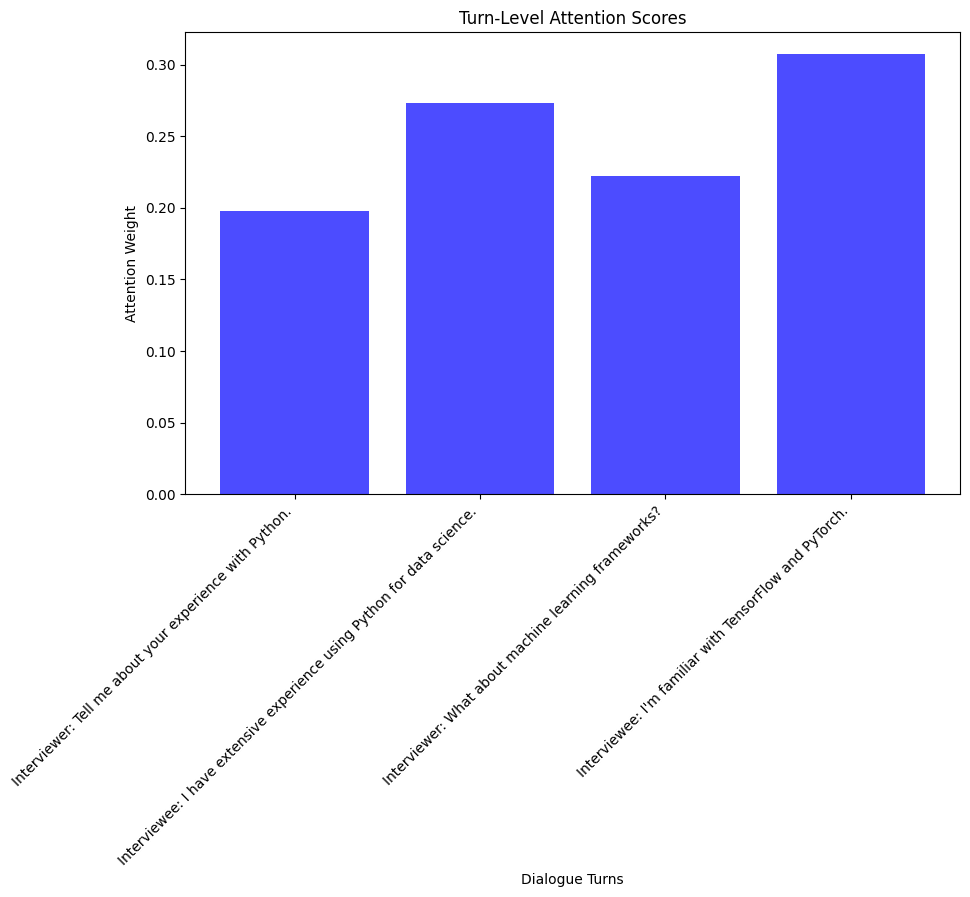

In [10]:
plot_attention_weights(attention_scores, new_dialogue)


NameError: name 'dialogue_turns' is not defined